In [1]:
# Import necessary libraries

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL  # Python Imaging Library (PIL)
import tensorflow as tf # TensorFlow is an open-source machine learning framework created by the Google Brain team
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import glob # The glob module finds all the pathnames matching a specified pattern
import pathlib #  Representing filesystem paths with semantics appropriate for different operating systems
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
# Download and explore the dataset
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228813984/228813984 [==============================] - 4s 0us/step


In [3]:
# Count total number of images in the dataset

# daisy: 633, dandelion: 898, roses: 641, sunflowers: 699,  tulips: 799
# Daisy
daisy_count = len(list(data_dir.glob('daisy/*.jpg'))) # The glob module finds all the pathnames matching a specified pattern
# Dandelion
dandelion_count = len(list(data_dir.glob('dandelion/*.jpg')))
# Roses
roses_count = len(list(data_dir.glob('roses/*.jpg')))
# Sunflowers
sunflowers_count = len(list(data_dir.glob('sunflowers/*.jpg')))
# Tulips
tulips_count = len(list(data_dir.glob('tulips/*.jpg')))

# Total
# Total flowers. All subfolders, then all jpg files
image_count = len(list(data_dir.glob('*/*.jpg')))

# Display
print("Total number of Daisy: ",daisy_count)
print("Total number of Dandelion: ",dandelion_count)
print("Total number of Roses: ",roses_count)
print("Total number of Sunflowers: ",sunflowers_count)
print("Total number of Tulips: ",tulips_count)
print("Total number of images in the dataset: ",image_count)

Total number of Daisy:  633
Total number of Dandelion:  898
Total number of Roses:  641
Total number of Sunflowers:  699
Total number of Tulips:  799
Total number of images in the dataset:  3670


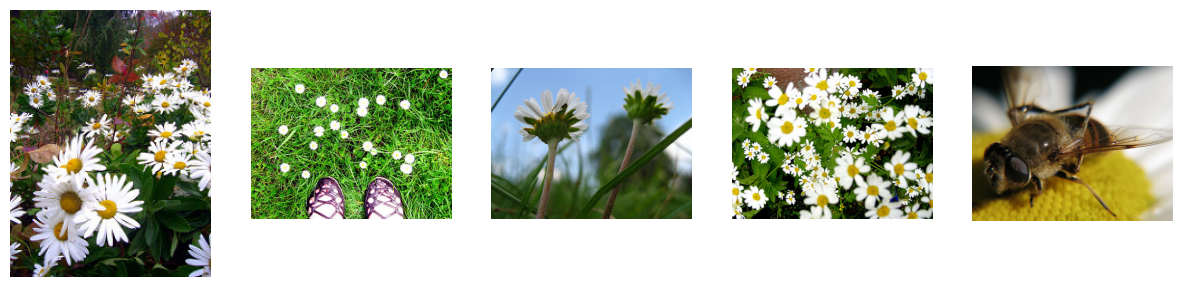

In [4]:
# Let's look into only "daisy" subfolder
daisies = list(data_dir.glob('daisy/*'))
#PIL.Image.open(roses[1])
# Display the first 5 images from the list
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    img = mpimg.imread(daisies[i])
    plt.imshow(img)
    plt.axis('off')
plt.show()

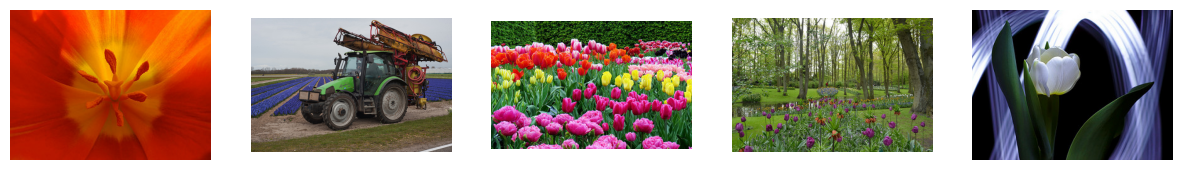

In [5]:
# Display some tulips
tulips = list(data_dir.glob('tulips/*'))
# Display the first 5 images from the list
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    img = mpimg.imread(tulips[i])
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [6]:
# Create a dataset for ML model
# Parameters, Set image size and number of images in each batch
batch_size = 32
img_height = 180
img_width = 180

In [7]:
# Data preprocessing
# Generates a tf.data.Dataset from image files in a directory by using tf.keras.preprocessing.image_dataset_from_directory.
# Split the image dataset into 8:2. Use 80% of the images for training, and 20% for validation

# Training data set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [8]:
# validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [9]:
# check the class names in the class_names attribute on these datasets
class_names = train_ds.class_names
print(class_names)
val_class_names = val_ds.class_names
print(val_class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


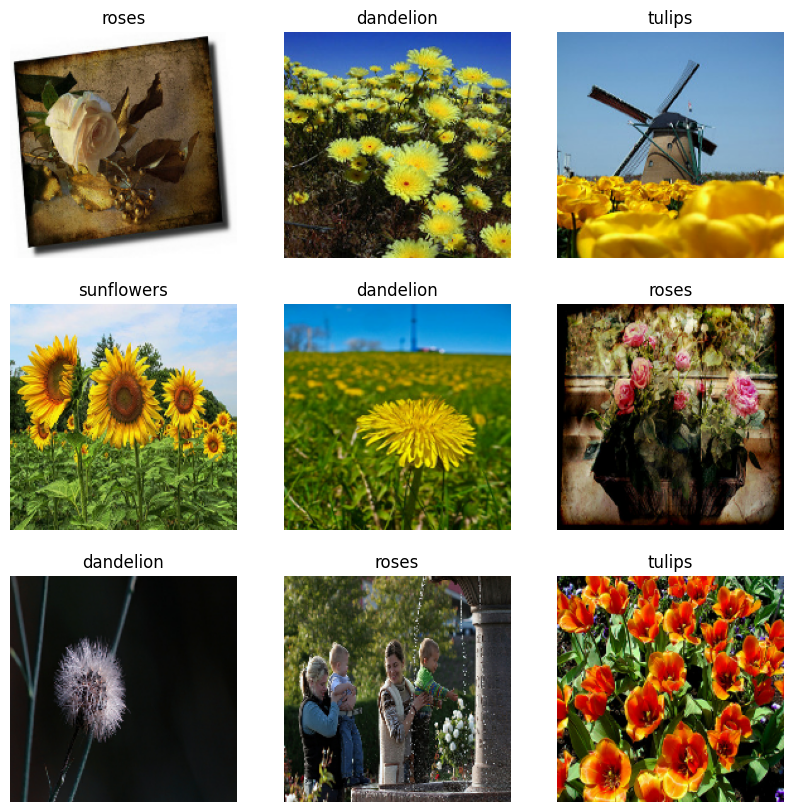

In [10]:
# Visualize the data
# Show 9 images from train dataset with image labels.
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
# The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB).
# The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

#print("Image Sahpe:", train_ds.shape)
for image_batch, labels_batch in train_ds:
  print("Image Shape with Batch:",image_batch.shape)
  print("Label batch Shape:",labels_batch.shape)
  break


Image Shape with Batch: (32, 180, 180, 3)
Label batch Shape: (32,)


In [12]:
# Configure the dataset for performance
# Use buffered prefetching to yield data from disk without having I/O become blocking
# Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.
# This will ensure the dataset does not become a bottleneck while training your model.
# Dataset.prefetch() overlaps data preprocessing and model execution while training.

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
# Standardize the data
# Preprocess images by normalizing the pixel values to be in the [0, 1] range (originally all values are in the [0, 255] range).
# All images will be rescaled by 1./255 (min-max normalization)
# This cell is optional. Let's do rescaling in the next cell

normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [14]:
# Create the model
# The model consists of three convolution blocks with a max pool layer in each of them.
# There's a fully connected layer with 128 units on top of it that is activated by a relu activation function.

num_classes = 5

model = Sequential([
  # All images will be rescaled by 1./255 (min-max normalization)
  # Image shape is (180x180x3)
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  # First convolution extracts 16 filters that are 3x3
  # Convolution is followed by max-pooling layer with a 2x2 window
  # Relu overcome vanishing gradient prolem, learning faster and better. Relu is default for Convolutional Neural Network.
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  # Second convolution extracts 32 filters that are 3x3
  # Convolution is followed by max-pooling layer with a 2x2 window
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  # Third convolution extracts 64 filters that are 3x3
  # Convolution is followed by max-pooling layer with a 2x2 window
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  # Flatten feature map to a 1-dim tensor so we can add fully connected layers
  layers.Flatten(),

  # Create a fully connected layer with ReLU activation and 128 hidden units
  layers.Dense(128, activation='relu'),

  # Create output layer with five classifier
  layers.Dense(num_classes)
])


In [15]:
# Compile the model
# Using the optimizers as Adam optimizer and losses, SparseCategoricalCrossentropy loss function.
# To view training and validation accuracy for each training epoch, pass the metrics argument.

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [16]:
# Model summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [17]:
# Train the model
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose = 2
)

Epoch 1/10
92/92 - 9s - loss: 1.2918 - accuracy: 0.4489 - val_loss: 1.1184 - val_accuracy: 0.5191 - 9s/epoch - 97ms/step
Epoch 2/10
92/92 - 2s - loss: 1.0059 - accuracy: 0.6097 - val_loss: 1.0261 - val_accuracy: 0.5817 - 2s/epoch - 21ms/step
Epoch 3/10
92/92 - 2s - loss: 0.7960 - accuracy: 0.7006 - val_loss: 0.8660 - val_accuracy: 0.6635 - 2s/epoch - 20ms/step
Epoch 4/10
92/92 - 2s - loss: 0.5805 - accuracy: 0.7871 - val_loss: 0.8955 - val_accuracy: 0.6717 - 2s/epoch - 19ms/step
Epoch 5/10
92/92 - 2s - loss: 0.3721 - accuracy: 0.8696 - val_loss: 0.9691 - val_accuracy: 0.6471 - 2s/epoch - 19ms/step
Epoch 6/10
92/92 - 2s - loss: 0.2316 - accuracy: 0.9247 - val_loss: 1.0796 - val_accuracy: 0.6676 - 2s/epoch - 19ms/step
Epoch 7/10
92/92 - 2s - loss: 0.1368 - accuracy: 0.9584 - val_loss: 1.3392 - val_accuracy: 0.6676 - 2s/epoch - 19ms/step
Epoch 8/10
92/92 - 2s - loss: 0.1087 - accuracy: 0.9649 - val_loss: 1.6155 - val_accuracy: 0.6267 - 2s/epoch - 20ms/step
Epoch 9/10
92/92 - 2s - loss: 0.

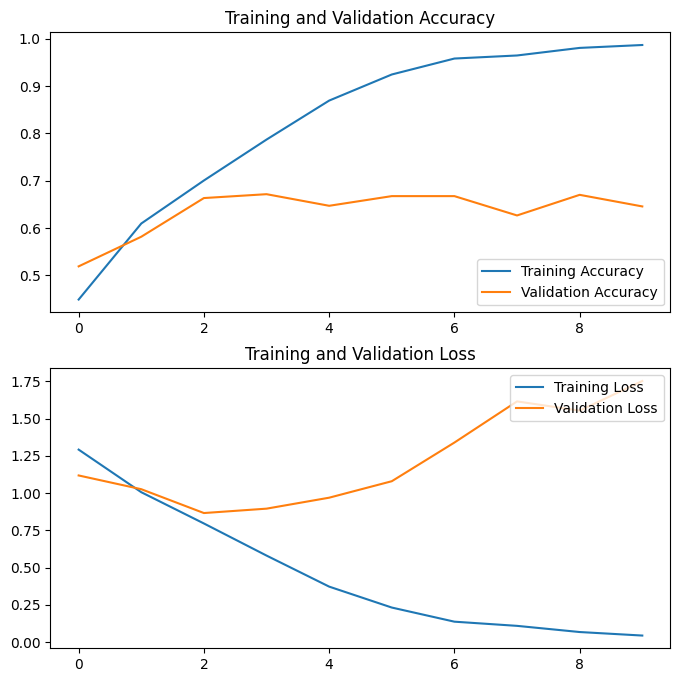

In [19]:
# Visualize training results
# Create plots of loss and accuracy on the training and validation sets

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [20]:
# print maximun accuracy on traning and validation data
# In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process.
# Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of overfitting.

print("Training Data Accuracy:",max(acc))
print("Validation Data Accuracy",max(val_acc))

Training Data Accuracy: 0.9870572090148926
Validation Data Accuracy 0.6716621518135071


In [21]:
# Use data augmentation and add Dropout to your model to overcome "overfitting".
# Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images.
# Implement data augmentation using the layers from tf.keras.layers.experimental.preprocessing. These can be included inside ML model like other layers, and run on the GPU.

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)


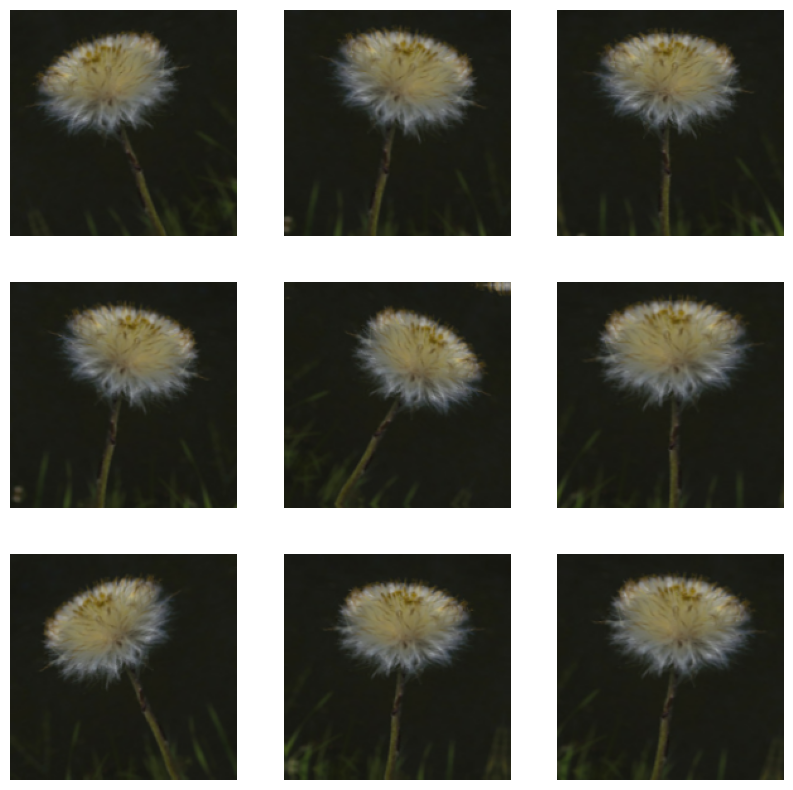

In [22]:
# Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [29]:
# Re design the same model with dropout layer
# Dropout
# When we apply Dropout to a layer it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process.
# Create a new neural network using layers.Dropout, then train it using augmented images.

num_classes =5

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2), # 20% dropout
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [30]:
# Compile and train the model

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [31]:
# Model summary

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                

In [32]:
# Train the model
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose = 1
)

Epoch 1/15
92/92 [==============================] - 6s 36ms/step - loss: 1.3646 - accuracy: 0.4111 - val_loss: 1.0740 - val_accuracy: 0.5627
Epoch 2/15
92/92 [==============================] - 3s 30ms/step - loss: 1.0742 - accuracy: 0.5712 - val_loss: 0.9861 - val_accuracy: 0.6035
Epoch 3/15
92/92 [==============================] - 3s 30ms/step - loss: 0.9541 - accuracy: 0.6356 - val_loss: 0.9867 - val_accuracy: 0.6226
Epoch 4/15
92/92 [==============================] - 3s 30ms/step - loss: 0.8762 - accuracy: 0.6659 - val_loss: 0.9241 - val_accuracy: 0.6349
Epoch 5/15
92/92 [==============================] - 3s 31ms/step - loss: 0.8485 - accuracy: 0.6788 - val_loss: 0.8502 - val_accuracy: 0.6608
Epoch 6/15
92/92 [==============================] - 3s 31ms/step - loss: 0.7822 - accuracy: 0.7033 - val_loss: 0.7886 - val_accuracy: 0.6962
Epoch 7/15
92/92 [==============================] - 3s 34ms/step - loss: 0.7356 - accuracy: 0.7245 - val_loss: 0.7426 - val_accuracy: 0.7084
Epoch 8/15
92

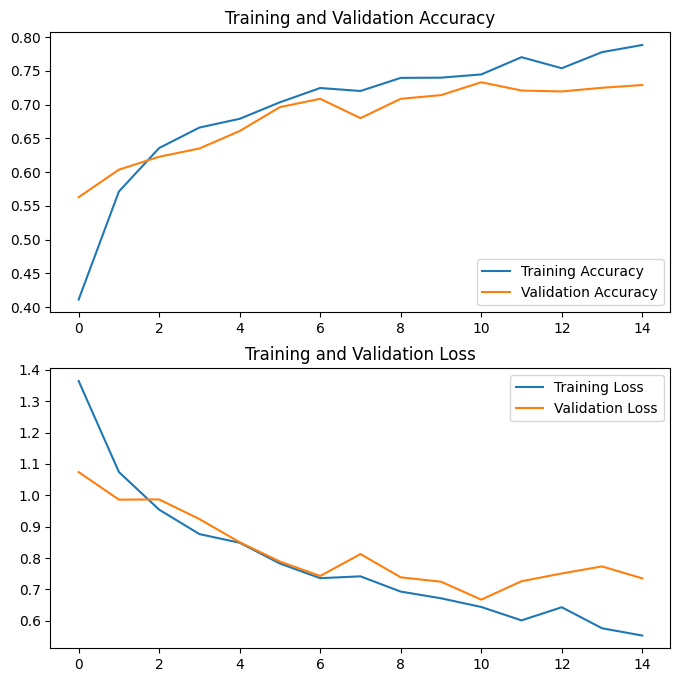

In [34]:
# After applying data augmentation and Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [37]:
# Diplay basic statistics
import statistics as st
print("The maximum training Data Accuracy:",max(acc))
print("The maximum validation Data Accuracy",max(val_acc))
print("Average training Data Accuracy:",st.mean(acc))
print("Average validation Data Accuracy",st.mean(val_acc))

The maximum training Data Accuracy: 0.7881471514701843
The maximum validation Data Accuracy 0.7329699993133545
Average training Data Accuracy: 0.6949137131373088
Average validation Data Accuracy 0.6811989068984985


In [38]:
# Predict on new data
# Note: Data augmentation and Dropout layers are inactive at inference time.

sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch (of zero)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 334ms/step
This image most likely belongs to sunflowers with a 96.95 percent confidence.
